In this tutorial, we study the family of SPDEs :

$$\left(\frac{\partial}{\partial t} + c\left[(1-\nabla H. \nabla)^{\alpha} + v.\nabla\right]\right)Z(s,t)=\sqrt{c}W_T(t)\otimes X_S(s)$$

where 

- $c>0$ is a time scale parameter
- $H$ is an anisotropic matrix 
- $v$ is a velocity vector
- $W_T$ is a temporal white-noise
- $X_S$ is a spatially structured  noise, solution of

    $$(1-\nabla H_S \nabla)X_S = \mathcal{W}_S$$

In [1]:
import numpy as np
import gstlearn as gl
from scipy.special import gamma

In [2]:
from sksparse.cholmod import cholesky
import scipy as sc
from scipy.sparse import diags

In [3]:
scale = 4.
kappa = 1./scale
kappa2 = kappa**2
dt = .1
c = 40
sqc = np.sqrt(c)
sqdt = np.sqrt(dt)

In [4]:
nx = [100,100]
m = gl.Model.createFromParam(gl.ECov.BESSEL_K,range=1,param=2,flagRange=False)
mesh = gl.MeshETurbo(nx ,[1,1])
S = gl.ShiftOpCs(mesh,m)
St = gl.csToTriplet(S.getS())
Smat=sc.sparse.csc_matrix((np.array(St.values), (np.array(St.rows), np.array(St.cols))),
                          shape=(St.nrows,St.ncols))
TildeC12 = diags(np.sqrt(S.getTildeC()))
invTildeC12 = diags(1./np.sqrt(S.getTildeC()))
G = TildeC12 @ Smat @ TildeC12
M = TildeC12 @ TildeC12
K = (kappa2 * M + G) @ (kappa2 * M + G) @ (kappa2 * M + G)
param = 3
P = M +  c*dt * K
cholP = cholesky(P)

def evalInvA(x) :
    return  cholP.solve_A(M @ x)

def evalInvB(x) :
    return sqc * sqdt * cholP.solve_A(TildeC12 @ x)

/tmp/ipykernel_30375/349625248.py:15: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  cholP = cholesky(P)


In [5]:
x = np.random.normal(size=Smat.shape[0])

for i in range(100):
    u = np.random.normal(size=Smat.shape[0])
    x = evalInvA(x) + evalInvB(u)

<IPython.core.display.Javascript object>


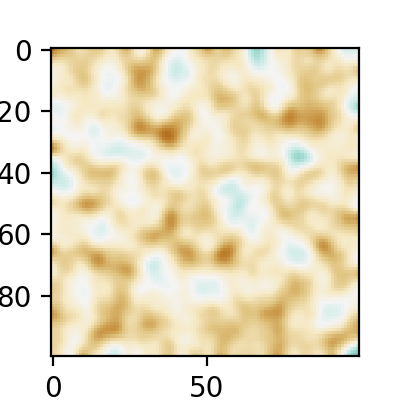

In [6]:
anim = True

if anim :
    %matplotlib notebook
    import matplotlib.pyplot as plt
    from matplotlib.animation import FuncAnimation
    #x = np.random.normal(size=Smat.shape[0])
    xtot = np.zeros(shape = [Smat.shape[0],50])
    xtot[:,0] = x
    fig, ax = plt.subplots(figsize=(2,2))
    ln = plt.imshow(x.reshape(nx), 'BrBG')

def init():
    ln.set_data(x.reshape(nx))
    return ln

def update(frame):
    u = np.random.normal(size=Smat.shape[0])
    xtot[:,frame] = evalInvA(xtot[:,frame-1]) + evalInvB(u)
    ln.set_data(xtot[:,frame].reshape(nx))
    return ln

if anim :
    ani = FuncAnimation(fig, update, frames = 50,
                        init_func=init, blit=False,interval=10)
    plt.show()


In [7]:
%matplotlib inline

In [8]:
model = gl.Model.createFromParam(gl.ECov.BESSEL_K,range = scale,param = param,flagRange=False)

rangev = 3.5 * model.getCova(0).getRange()
h = np.linspace(0,rangev,100)
points = [gl.SpacePoint([0.,i]) for i in h]
cov = [model.eval(0,0,points[0],i) for i in points]

In [9]:
def correc(kappa,alpha,d=2):
    return gamma(alpha-d/2)/ (gamma(alpha)*(4*np.pi)**(d/2)*kappa**(2*alpha-d))
    

In [28]:
d = 2
param = 3
alpha = param+d/2
hmax = 3.5 * model.getCova(0).getRange()
N = 2**8


ind = np.concatenate([np.arange(int(N/2),N-1,2),np.arange(0,int(N/2),2)])

a= np.pi * (N-1) / hmax
v = np.linspace(-1.,1.,N)
u = a/2 * v
deltau=a/(N-1)

xi = np.meshgrid(u,u)
normxi = np.array([i**2 + j**2 for i in u for j in u]).reshape((len(u),len(u)))

grxi = c * (kappa2 + normxi)**alpha * correc(kappa,param+d/2,d)

nres = 200
time = np.arange(0,nres,1) 
result = np.zeros(shape=[len(ind),nres])
for k in time :
    fourier = np.exp(-k *dt * np.abs(grxi))/(  1./c * (2*np.pi)**d*2*grxi)
    B = np.real(np.fft.fftn(fourier,norm="backward"))
    result[:,k] = B[0,:][ind]
    

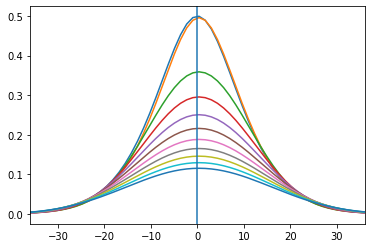

In [38]:
X= np.pi * v[np.arange(0,N,2)] /deltau 
points = [gl.SpacePoint([0.,i]) for i in X]
cov = [model.eval(0,0,gl.SpacePoint([0.,0]),i)/2. for i in points]
 

plt.plot(X,cov)
for i in range(10):
    covZ=result[:,i * 10]*deltau**d
    plt.plot(X, covZ)


lim = 1.5 * model.getCova(0).getRange()
plt.xlim([-lim,lim])
plt.axvline(x=0.)

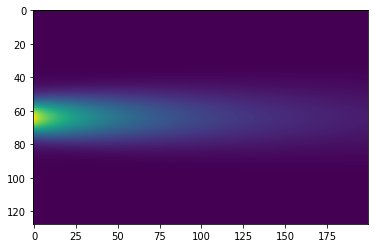

In [39]:
plt.imshow(result)

In [40]:
v

array([-1.        , -0.99215686, -0.98431373, -0.97647059, -0.96862745,
       -0.96078431, -0.95294118, -0.94509804, -0.9372549 , -0.92941176,
       -0.92156863, -0.91372549, -0.90588235, -0.89803922, -0.89019608,
       -0.88235294, -0.8745098 , -0.86666667, -0.85882353, -0.85098039,
       -0.84313725, -0.83529412, -0.82745098, -0.81960784, -0.81176471,
       -0.80392157, -0.79607843, -0.78823529, -0.78039216, -0.77254902,
       -0.76470588, -0.75686275, -0.74901961, -0.74117647, -0.73333333,
       -0.7254902 , -0.71764706, -0.70980392, -0.70196078, -0.69411765,
       -0.68627451, -0.67843137, -0.67058824, -0.6627451 , -0.65490196,
       -0.64705882, -0.63921569, -0.63137255, -0.62352941, -0.61568627,
       -0.60784314, -0.6       , -0.59215686, -0.58431373, -0.57647059,
       -0.56862745, -0.56078431, -0.55294118, -0.54509804, -0.5372549 ,
       -0.52941176, -0.52156863, -0.51372549, -0.50588235, -0.49803922,
       -0.49019608, -0.48235294, -0.4745098 , -0.46666667, -0.45

In [44]:
result[:,0].max()

357.4611315408981